In [5]:
"""
Author:
Niklas Santeri Kuusisto

The following works were referenced in implementing the code:
    
    Q. Shi, J. Yin, J. Cai, A. Cichocki, T. Yokota, L. Chen, M. Yuan, and J. Zeng,
    “BlockHankel Tensor ARIMA for Multiple Short Time Series Forecasting,” 2020, 
    Proceedings of AAAI.

    Y. Yang, D. Krompass, and V. Tresp, “Tensor-Train Recurrent Neural Networks for
    Video Classification,” 2017, ICML.

    A. Novikov, D. Podoprikhin, A. Osokin, and D. Vetrov, “Tensorizing Neural Networks,”
    2015, Advances in Neural Information Processing Systems 28.

    Y. L. Xu, G. G. Calvi, and D. P. Mandic, “Tensor-Train Recurrent Neural Networks for
    Interpretable Multi-Way Financial Forecasting,” 2021, arXiv e-prints.

    Y. L. Xu, “Tensor-Train Recurrent Neural Networks in Financial Forecasting,”
    2019, Final Year Project, Department of Electrical and Electronic Engineering,
    Imperial College London.
"""

%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Version

In [3]:
!pip uninstall keras-nightly

Uninstalling keras-nightly-2.5.0.dev2021032900:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/keras/*
    /usr/local/lib/python3.7/dist-packages/keras_nightly-2.5.0.dev2021032900.dist-info/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.7/dist-packages/keras/applications/resnet50.py
    /usr/local/lib/python3.7/dist-packages/keras/engine/network.py
    /usr/local/lib/python3.7/dist-packages/keras/engine/topology.py
    /usr/local/lib/python3.7/dist-packages/keras/initializers.py
    /usr/local/lib/python3.7/dist-packages/keras/layers/experimental/__init__.py
    /usr/local/lib/python3.7/dist-packages/keras/layers/experimental/preprocessing/__init__.py
    /usr/local/lib/python3.7/dist-packages/keras/objectives.py
    /usr/local/lib/python3.7/dist-packages/keras/optimizers/__init__.py
    /usr/local/lib/python3.7/dist-packages/keras/optimizers/schedules/__init__.py
    /usr/local/lib/python3.7/dist-packages/keras/utils/test_utils.py
Proceed (y/n)?

In [4]:
!pip install tensorflow==1.*
!pip install tensorflow-gpu==1.15
!pip install keras==2.2.4.

# restart runtime

     |████████████████████████████████| 110.5MB 86kB/s 
     |████████████████████████████████| 20.1MB 10.1MB/s 
     |████████████████████████████████| 2.9MB 34.9MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
     |████████████████████████████████| 3.8MB 33.3MB/s 
     |████████████████████████████████| 512kB 27.1MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7557 sha256=2725080a282bad5c5a87ed0ee8a000382b2be2b61701fc13adb3eed8391737ac
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
ERROR: kapre 0.3.5 has requirement tensorflow>=2.0.0, but you'll have tensorflow 1.15.5 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<

     |████████████████████████████████| 411.5MB 45kB/s 


     |████████████████████████████████| 317kB 11.8MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


# Imports

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

from google.colab import drive

In [2]:
from keras import backend as K
from keras.layers import Layer
from keras import activations
from keras import initializers
from keras.layers import Dense, SimpleRNN, Flatten
from keras.layers.recurrent import Recurrent
from keras.models import Sequential
from keras.optimizers import sgd
from keras.utils.np_utils import to_categorical

from tensorflow import set_random_seed as tf_random_seed
import tensorflow as tf

Using TensorFlow backend.


In [3]:
np.random.seed(100)
tf_random_seed(100)

In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# TT Recurrent Layer

In [6]:
class TTRecurrentLayer(Recurrent):
    def __init__(self, tt_input, tt_output, tt_ranks, activation='tanh', kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', **kwargs):
        self.tt_input = np.array(tt_input)
        self.tt_output = np.array(tt_output)
        self.tt_ranks = np.array(tt_ranks)
        self.num_dim = self.tt_input.shape[0]
        self.parameters = np.sum(self.tt_input*self.tt_output*self.tt_ranks[1:]*self.tt_ranks[:-1])
        self.units = np.prod(np.array(tt_output))
        self.activation = activations.get(activation)
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.recurrent_initializer = initializers.get(recurrent_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

        super(TTRecurrentLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.states = [None]
        if self.stateful:
            self.reset_states()

        self.kernel = self.add_weight((self.parameters,), initializer=self.kernel_initializer, name='kernel')
        self.bias = self.add_weight((np.prod(self.tt_output), ), initializer=self.bias_initializer, name='bias')

        self.indices = np.zeros(self.num_dim).astype('int32')
        self.shapes = np.zeros((self.num_dim, 2)).astype('int32')
        self.cores = [None] * self.num_dim

        for k in range(self.num_dim - 1, -1, -1):
            self.shapes[k] = (self.tt_input[k] * self.tt_ranks[k + 1], self.tt_ranks[k] * self.tt_output[k])
            self.cores[k] = self.kernel[self.indices[k]:self.indices[k] + np.prod(self.shapes[k])]
            if 0 < k:
                self.indices[k - 1] = self.indices[k] + np.prod(self.shapes[k])

        self.recurrent_kernel = self.add_weight(shape=(self.units, self.units),name='recurrent_kernel',initializer=self.recurrent_initializer)
        
        fully_connected_params = (np.prod(self.tt_input) * np.prod(self.tt_output))

        print ('Model TT ranks: ' + str(self.tt_ranks))
        print ('TT number of parameters: ', self.parameters)
        print ('Equivalent fully connected layer parameters: ', fully_connected_params)
        
    def preprocess_input(self, x, training=None):
        return x

    def step(self, x, states):
        res = x
        for i in range(self.num_dim - 1, -1, -1):
            res = K.dot(K.reshape(res, (-1, self.shapes[i][0])), K.reshape(self.cores[i], self.shapes[i]))
            res = K.transpose(K.reshape(res, (-1, self.tt_output[i])))
        res = K.transpose(K.reshape(res, (-1, K.shape(x)[0])))
                
        h = res + self.bias

        prev_output = states[0]
        output = h + K.dot(prev_output, self.recurrent_kernel)
        output = self.activation(output)

        return output, [output]

# Models

In [8]:
def create_RNN(n=1024, lr=1e-3):
    model = Sequential()
    model.add(SimpleRNN(units=n,activation='tanh', return_sequences=False))
    model.add(Dense(units=3, activation='softmax'))
    model.compile(optimizer=sgd(lr), loss='categorical_crossentropy', metrics=['acc'])
    return model

In [7]:
def create_TTRNN(tt_input, tt_output, tt_ranks, lr=1e-3):
    model = Sequential()
    model.add(TTRecurrentLayer(tt_input, tt_output, tt_ranks, activation='tanh', return_sequences=False)) # activation sigmoid to introduce gating instead
    model.add(Dense(units=3, activation='softmax'))
    model.compile(optimizer=sgd(lr), loss='categorical_crossentropy', metrics=['acc'])
    return model

# Utility Functions

In [8]:
def maximum_drawdown(input):
  x = input.cumsum().values
  i = np.argmax(np.maximum.accumulate(x)-x) 
  j = np.argmax(x[:i])
  return (x[i]-x[j]), (i-j)

In [9]:
def trading_results(input):
  df = pd.Series()
  df['Total return (%)'] = sum(input)
  df['Accuracy (%)'] = 100*len(input[input>0])/len(input)
  df['Average return (%)'] = input.mean()
  df['Maximum drawdown (%)'] = maximum_drawdown(input)[0]
  df['Drawdown duration (Days)'] = maximum_drawdown(input)[1]
  df['Sharpe ratio'] = input.mean()/input.std()
  df['Skew'] = input.skew()
  df['Kurtosis'] = input.kurtosis()
  return df

In [10]:
def get_data(ticker, input_path = 'drive/My Drive/FYP Data/'):
    input_file = input_path+ticker+'.csv'
    data = pd.read_csv(input_file, header=0, index_col=0)
    data.index = pd.to_datetime(data.index)
    data = data.astype(float)
    data = data.sort_index()
    return data

In [11]:
tickers = ['DAX','NKY','SPX','USDJPY','USDEUR','USDGBP','ZG','T','NG','DE10YT','JP10YT','US10YT']

# Standard Recurrent Neural Network Model

## Pre-processing of Data

In [14]:
labels = pd.read_csv('drive/My Drive/FYP Data/labels.csv', index_col=0, header=0)
output = np.sign(labels['SPX'])+1 # 0,1,2 or negative, neutral, positive
output = to_categorical(output)

In [15]:
X = np.zeros((3735,180)) # 3735 time steps, 180 = 15*3*4

for ticker in tickers:
  tmp_idx1 = tickers.index(ticker)*15
  tmp_idx2 = tmp_idx1+15
  X[:, tmp_idx1:tmp_idx2] = get_data(ticker).values

In [16]:
split_idx = int(3735*0.9)
X_train = X[:split_idx]
X_test = X[split_idx:]
y_train = output[:split_idx]
y_test = output[split_idx:]

In [17]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
time_step = 22

RNN_X_train = np.zeros((X_train.shape[0]-time_step,time_step,180))
RNN_y_train = np.zeros((y_train.shape[0]-time_step,y_train.shape[1]))
RNN_X_test = np.zeros((X_test.shape[0]-time_step,time_step,180))
RNN_y_test = np.zeros((y_test.shape[0]-time_step,y_test.shape[1]))

for i in range(time_step, X_train.shape[0]):
  RNN_X_train[i-time_step] = X_train[i-time_step:i]
  RNN_y_train[i-time_step] = y_train[:i][-1]
  
for i in range(time_step, X_test.shape[0]):
  RNN_X_test[i-time_step]=X_test[i-time_step:i]
  RNN_y_test[i-time_step]=y_test[:i][-1]

## Model Training

In [19]:
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

epochs = 20
batch_size = 22*3
model = create_RNN()

start_time = datetime.now()
for e in range(epochs):
    print('epoch: ', e)
    history = model.fit(x=RNN_X_train, y=RNN_y_train, verbose=1, epochs=1, batch_size=batch_size, validation_split=0.1)

    train_loss.append(history.history['loss'][0])
    valid_loss.append(history.history['val_loss'][0])
    train_acc.append(history.history['acc'][0]*100)
    valid_acc.append(history.history['val_acc'][0]*100)

print('Time elapsed: ', datetime.now()-start_time)



epoch:  0



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 3005 samples, validate on 334 samples
Epoch 1/1





3005/3005 [==============================] - 3s 862us/step - loss: 1.2521 - acc: 0.3381 - val_loss: 1.3561 - val_acc: 0.2605
epoch:  1
Train on 3005 samples, validate on 334 samples
Epoch 1/1
3005/3005 [==============================] - 2s 547us/step - loss: 1.1884 - acc: 0.3561 - val_loss: 1.3237 - val_acc: 0.2605
epoch:  2
Train on 3005 samples, validate on 334 samples
Epoch 1/1
3005/3005 [==============================] - 2s 534us/step - loss: 1.1414 - acc: 0.3827 - val_loss: 1.3047 - val_acc: 0.2575
epoch:  3
Train on 3005 samples, validate on 334 samples
Epoch 1/1
3005/3005 [==============================] - 2s 529us/step - loss: 1.1029 - acc: 0.4083 - val_loss: 1.2919 - val_acc: 0.2515
epoch:  4
Train on 3005 samples, validate on 334 samples
Epoch 1/1
3005/3005 [==============================] - 2s 527us/step

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 1024)              1233920   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3075      
Total params: 1,236,995
Trainable params: 1,236,995
Non-trainable params: 0
_________________________________________________________________


## Analysis

train loss:  0.8072562766154475
validation loss:  1.1637227435311872 

train accuracy:  61.86356025606939
validation accuracy:  34.13173694632011 



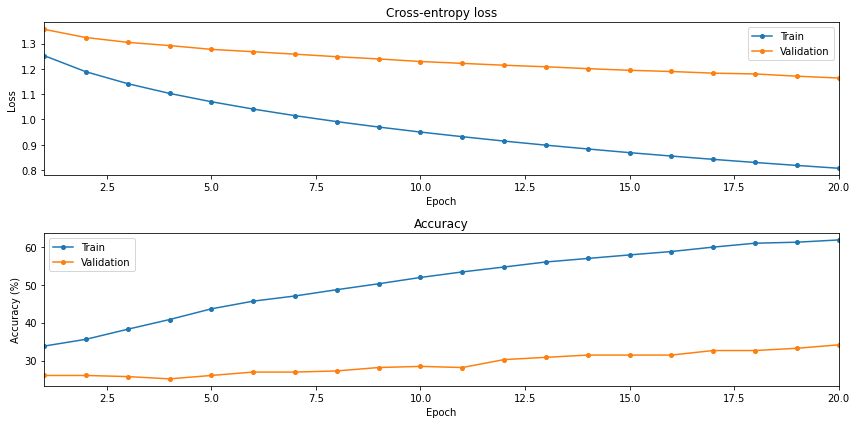

In [21]:
fig, axes = plt.subplots(2,1)

ax=axes[0]
ax.plot([i for i in range(1,epochs+1)], train_loss, marker='o', markersize=4)
ax.plot([i for i in range(1,epochs+1)], valid_loss, marker='o', markersize=4)
ax.legend(['Train', 'Validation'],loc='best')
ax.set_title('Cross-entropy loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_xlim([1,20])

ax=axes[1]
ax.plot([i for i in range(1,epochs+1)], train_acc, marker='o', markersize=4)
ax.plot([i for i in range(1,epochs+1)], valid_acc, marker='o', markersize=4)
ax.legend(['Train', 'Validation'],loc='best')
ax.set_title('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (%)')
ax.set_xlim([1,20])

fig.set_size_inches(12,6)
fig.tight_layout()

print('train loss: ',train_loss[19])
print('validation loss: ', valid_loss[19], '\n')
print('train accuracy: ',train_acc[19])
print('validation accuracy: ', valid_acc[19], '\n')

## Backtest

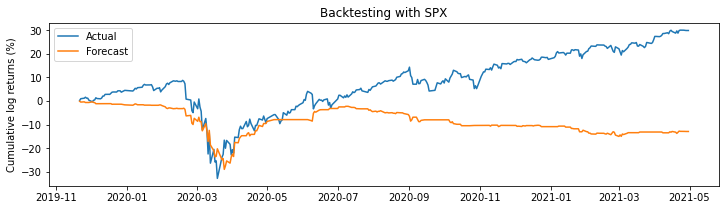

In [26]:
returns = labels['SPX'][-RNN_y_test.shape[0]:]*100

idx = model.predict(RNN_X_test).argmax(1)-1
idx = idx*model.predict(RNN_X_test).max(1)

predicted = returns*idx

returns.index = pd.to_datetime(returns.index)
predicted.index = pd.to_datetime(predicted.index)

fig, axes =  plt.subplots()
axes.plot(returns.cumsum())
axes.plot(predicted.cumsum())
axes.legend(['Actual', 'Forecast'], loc='best')
axes.set_title('Backtesting with SPX')
axes.set_ylabel('Cumulative log returns (%)')
fig.set_size_inches(12,3)

In [29]:
trading_results(predicted)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Total return (%)           -12.887647
Accuracy (%)                23.579545
Average return (%)          -0.036613
Maximum drawdown (%)       -28.793144
Drawdown duration (Days)    81.000000
Sharpe ratio                -0.038219
Skew                        -0.673401
Kurtosis                    16.117346
dtype: float64

In [30]:
# test results
score = model.evaluate(RNN_X_test,RNN_y_test, batch_size=22*3)
score

352/352 [==============================] - 0s 330us/step


[1.250395692884922, 0.26988636888563633]

# TT Recurrent Neural Network Model

## Pre-processing of Data

In [12]:
labels = pd.read_csv('drive/My Drive/FYP Data/labels.csv', index_col=0, header=0)
output = np.sign(labels['SPX'])+1 # 0,1,2 or negative, neutral, positive
output = to_categorical(output)

In [13]:
X = np.zeros((3735,180))

for ticker in tickers:
  tmp_idx1 = tickers.index(ticker)*15
  tmp_idx2 = tmp_idx1+15
  X[:, tmp_idx1:tmp_idx2] = get_data(ticker).values

In [14]:
split_idx = int(3735*0.9)

X_train = X[:split_idx]
X_test = X[split_idx:]
y_train = output[:split_idx]
y_test = output[split_idx:]

In [15]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
time_step = 22

RNN_X_train = np.zeros((X_train.shape[0]-time_step,time_step,180))
RNN_y_train = np.zeros((y_train.shape[0]-time_step,y_train.shape[1]))
RNN_X_test = np.zeros((X_test.shape[0]-time_step,time_step,180))
RNN_y_test = np.zeros((y_test.shape[0]-time_step,y_test.shape[1]))

for i in range(time_step, X_train.shape[0]):
  RNN_X_train[i-time_step]=X_train[i-time_step:i]
  RNN_y_train[i-time_step]=y_train[:i][-1]
  
for i in range(time_step, X_test.shape[0]):
  RNN_X_test[i-time_step]=X_test[i-time_step:i]
  RNN_y_test[i-time_step]=y_test[:i][-1]

## Model Training

In [17]:
epochs = 20
batch_size = 22*3
ranks = [1,2,3,4,5,6,7,8,9,10]
parameters = []

# so far tried:
# 1x5x3x4x3 best
# 1x5x3x3x4 not good
# 1x3x5x4x3 not good

tt_input = [1,5,3,4,3]
tt_output = [4,4,4,4,4]

train_losses = pd.Series()
test_losses = pd.Series()
trading_res = pd.DataFrame()
best_return = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  from ipykernel import kernelapp as app


In [18]:
for r in ranks:
  tt_ranks = [1,r,r,r,r,1]
  model = create_TTRNN(tt_input,tt_output,tt_ranks)

  train_loss = []
  valid_loss = []
  train_acc = []
  valid_acc = []

  weights_XH = []
  weights_HH = []

  for e in range(epochs):
      print('epoch: ', e)
      history = model.fit(x=RNN_X_train, y=RNN_y_train, verbose=1, epochs=1, batch_size=batch_size, validation_split=0.1)
      train_loss.append(history.history['loss'][0])
      valid_loss.append(history.history['val_loss'][0])
      train_acc.append(history.history['acc'][0]*100)
      valid_acc.append(history.history['val_acc'][0]*100)

      weights = model.get_weights()
      weights_XH.append(weights[0])
      weights_HH.append(weights[2])

  parameters.append(np.sum(np.array(tt_input)*np.array(tt_output)*np.array(tt_ranks)[1:]*np.array(tt_ranks)[:-1]))

  if not r in trading_res.columns:
    train_losses[str(r)] = model.evaluate(RNN_X_train, RNN_y_train, verbose=0)[0]
    test_losses[str(r)] = model.evaluate(RNN_X_test, RNN_y_test, verbose=0)[0]
  
  returns = labels['SPX'][-RNN_y_test.shape[0]:]*100
  idx = model.predict(RNN_X_test).argmax(1)-1
  idx = idx*model.predict(RNN_X_test).max(1)
  predicted = returns*idx

  if not r in trading_res.columns:
    trading_res[r] = trading_results(predicted)
    print(trading_res)
  if trading_res[r]['Accuracy (%)'] > 0.5:
    if trading_res[r]['Total return (%)'] > best_return:
      best_return = trading_res[r]['Total return (%)']
      best_model = model
      best_result = trading_res[r]['Total return (%)']
      best_train_loss = train_loss
      best_valid_loss = valid_loss
      best_train_acc = train_acc
      best_valid_acc = valid_acc
      best_weights_XH = weights_XH
      best_weights_HH = weights_HH



epoch:  0


Model TT ranks: [1 1 1 1 1 1]
TT number of parameters:  64
Equivalent fully connected layer parameters:  184320

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 3005 samples, validate on 334 samples
Epoch 1/1





3005/3005 [==============================] - 4s 1ms/step - loss: 1.0577 - acc: 0.4183 - val_loss: 1.0359 - val_acc: 0.4431
epoch:  1
Train on 3005 samples, validate on 334 samples
Epoch 1/1
3005/3005 [==============================] - 2s 770us/step - loss: 0.9344 - acc: 0.4972 - val_loss: 0.9021 - val_acc: 0.4790
epoch:  2
Train on 3005 samples, validate on 334 samples
Epoch 1/1
3005/3005 [==============================] - 2s 778us/step - loss: 0.8500 - acc: 0.5171 - val_loss: 0.8485 - val_acc: 0.4850
epoch:  3
Train on 3005 samples, validate on 334 samples
Epoch 1/1
3005/3005 [==============================] - 2s 761us/step - loss: 0.8335 - acc: 0.5171 - val_loss: 0.8396 - val_acc: 0.5090
epoch:  4
Train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


                                  1
Total return (%)           9.715103
Accuracy (%)              54.261364
Average return (%)         0.027600
Maximum drawdown (%)     -17.131367
Drawdown duration (Days)  28.000000
Sharpe ratio               0.027154
Skew                      -1.307246
Kurtosis                   9.755881
epoch:  0
Model TT ranks: [1 2 2 2 2 1]
TT number of parameters:  224
Equivalent fully connected layer parameters:  184320
Train on 3005 samples, validate on 334 samples
Epoch 1/1
3005/3005 [==============================] - 3s 983us/step - loss: 1.0516 - acc: 0.4097 - val_loss: 1.0148 - val_acc: 0.4820
epoch:  1
Train on 3005 samples, validate on 334 samples
Epoch 1/1
3005/3005 [==============================] - 2s 757us/step - loss: 0.9125 - acc: 0.4922 - val_loss: 0.8875 - val_acc: 0.5479
epoch:  2
Train on 3005 samples, validate on 334 samples
Epoch 1/1
3005/3005 [==============================] - 2s 760us/step - loss: 0.8490 - acc: 0.5088 - val_loss: 0.8417 - val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


                                  1          2
Total return (%)           9.715103   6.372653
Accuracy (%)              54.261364  51.136364
Average return (%)         0.027600   0.018104
Maximum drawdown (%)     -17.131367 -21.384362
Drawdown duration (Days)  28.000000  67.000000
Sharpe ratio               0.027154   0.016712
Skew                      -1.307246  -1.026769
Kurtosis                   9.755881  14.360612
epoch:  0
Model TT ranks: [1 3 3 3 3 1]
TT number of parameters:  480
Equivalent fully connected layer parameters:  184320
Train on 3005 samples, validate on 334 samples
Epoch 1/1
3005/3005 [==============================] - 3s 1ms/step - loss: 1.0811 - acc: 0.4010 - val_loss: 1.0739 - val_acc: 0.4012
epoch:  1
Train on 3005 samples, validate on 334 samples
Epoch 1/1
3005/3005 [==============================] - 3s 846us/step - loss: 0.9774 - acc: 0.4895 - val_loss: 0.9737 - val_acc: 0.4880
epoch:  2
Train on 3005 samples, validate on 334 samples
Epoch 1/1
3005/3005 [====

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


                                  1          2          3
Total return (%)           9.715103   6.372653  24.767446
Accuracy (%)              54.261364  51.136364  51.704545
Average return (%)         0.027600   0.018104   0.070362
Maximum drawdown (%)     -17.131367 -21.384362 -10.842586
Drawdown duration (Days)  28.000000  67.000000  38.000000
Sharpe ratio               0.027154   0.016712   0.072237
Skew                      -1.307246  -1.026769   1.198377
Kurtosis                   9.755881  14.360612  10.044680
epoch:  0
Model TT ranks: [1 4 4 4 4 1]
TT number of parameters:  832
Equivalent fully connected layer parameters:  184320
Train on 3005 samples, validate on 334 samples
Epoch 1/1
3005/3005 [==============================] - 3s 1ms/step - loss: 1.0324 - acc: 0.4473 - val_loss: 0.9735 - val_acc: 0.5000
epoch:  1
Train on 3005 samples, validate on 334 samples
Epoch 1/1
3005/3005 [==============================] - 3s 856us/step - loss: 0.8883 - acc: 0.5018 - val_loss: 0.8518 -

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


                                  1          2          3           4
Total return (%)           9.715103   6.372653  24.767446  -18.540654
Accuracy (%)              54.261364  51.136364  51.704545   48.011364
Average return (%)         0.027600   0.018104   0.070362   -0.052672
Maximum drawdown (%)     -17.131367 -21.384362 -10.842586  -29.273461
Drawdown duration (Days)  28.000000  67.000000  38.000000  258.000000
Sharpe ratio               0.027154   0.016712   0.072237   -0.045985
Skew                      -1.307246  -1.026769   1.198377   -1.427992
Kurtosis                   9.755881  14.360612  10.044680   17.844920
epoch:  0
Model TT ranks: [1 5 5 5 5 1]
TT number of parameters:  1280
Equivalent fully connected layer parameters:  184320
Train on 3005 samples, validate on 334 samples
Epoch 1/1
3005/3005 [==============================] - 4s 1ms/step - loss: 1.0251 - acc: 0.4453 - val_loss: 0.9290 - val_acc: 0.4970
epoch:  1
Train on 3005 samples, validate on 334 samples
Epoch 1/1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


                                  1          2  ...           4           5
Total return (%)           9.715103   6.372653  ...  -18.540654    4.596478
Accuracy (%)              54.261364  51.136364  ...   48.011364   47.727273
Average return (%)         0.027600   0.018104  ...   -0.052672    0.013058
Maximum drawdown (%)     -17.131367 -21.384362  ...  -29.273461  -15.406494
Drawdown duration (Days)  28.000000  67.000000  ...  258.000000  160.000000
Sharpe ratio               0.027154   0.016712  ...   -0.045985    0.012062
Skew                      -1.307246  -1.026769  ...   -1.427992    1.121411
Kurtosis                   9.755881  14.360612  ...   17.844920   16.002665

[8 rows x 5 columns]
epoch:  0
Model TT ranks: [1 6 6 6 6 1]
TT number of parameters:  1824
Equivalent fully connected layer parameters:  184320
Train on 3005 samples, validate on 334 samples
Epoch 1/1
3005/3005 [==============================] - 4s 1ms/step - loss: 1.0330 - acc: 0.4539 - val_loss: 0.9659 - val_ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


                                  1          2  ...           5           6
Total return (%)           9.715103   6.372653  ...    4.596478  -15.285607
Accuracy (%)              54.261364  51.136364  ...   47.727273   47.159091
Average return (%)         0.027600   0.018104  ...    0.013058   -0.043425
Maximum drawdown (%)     -17.131367 -21.384362  ...  -15.406494  -21.948732
Drawdown duration (Days)  28.000000  67.000000  ...  160.000000  125.000000
Sharpe ratio               0.027154   0.016712  ...    0.012062   -0.041498
Skew                      -1.307246  -1.026769  ...    1.121411    0.697627
Kurtosis                   9.755881  14.360612  ...   16.002665   12.649032

[8 rows x 6 columns]
epoch:  0
Model TT ranks: [1 7 7 7 7 1]
TT number of parameters:  2464
Equivalent fully connected layer parameters:  184320
Train on 3005 samples, validate on 334 samples
Epoch 1/1
3005/3005 [==============================] - 4s 1ms/step - loss: 1.0278 - acc: 0.4622 - val_loss: 0.9458 - val_ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


                                  1          2  ...           6           7
Total return (%)           9.715103   6.372653  ...  -15.285607  -40.138951
Accuracy (%)              54.261364  51.136364  ...   47.159091   43.181818
Average return (%)         0.027600   0.018104  ...   -0.043425   -0.114031
Maximum drawdown (%)     -17.131367 -21.384362  ...  -21.948732  -50.419025
Drawdown duration (Days)  28.000000  67.000000  ...  125.000000  154.000000
Sharpe ratio               0.027154   0.016712  ...   -0.041498   -0.107609
Skew                      -1.307246  -1.026769  ...    0.697627   -1.892716
Kurtosis                   9.755881  14.360612  ...   12.649032   12.393906

[8 rows x 7 columns]
epoch:  0
Model TT ranks: [1 8 8 8 8 1]
TT number of parameters:  3200
Equivalent fully connected layer parameters:  184320
Train on 3005 samples, validate on 334 samples
Epoch 1/1
3005/3005 [==============================] - 4s 1ms/step - loss: 1.0349 - acc: 0.4326 - val_loss: 0.9483 - val_ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


                                  1          2  ...           7          8
Total return (%)           9.715103   6.372653  ...  -40.138951   4.788363
Accuracy (%)              54.261364  51.136364  ...   43.181818  50.852273
Average return (%)         0.027600   0.018104  ...   -0.114031   0.013603
Maximum drawdown (%)     -17.131367 -21.384362  ...  -50.419025 -17.597923
Drawdown duration (Days)  28.000000  67.000000  ...  154.000000  39.000000
Sharpe ratio               0.027154   0.016712  ...   -0.107609   0.012586
Skew                      -1.307246  -1.026769  ...   -1.892716  -0.844267
Kurtosis                   9.755881  14.360612  ...   12.393906  12.441029

[8 rows x 8 columns]
epoch:  0
Model TT ranks: [1 9 9 9 9 1]
TT number of parameters:  4032
Equivalent fully connected layer parameters:  184320
Train on 3005 samples, validate on 334 samples
Epoch 1/1
3005/3005 [==============================] - 4s 1ms/step - loss: 0.9923 - acc: 0.4679 - val_loss: 0.9051 - val_acc: 0.5210

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


                                  1          2  ...          8           9
Total return (%)           9.715103   6.372653  ...   4.788363    5.158940
Accuracy (%)              54.261364  51.136364  ...  50.852273   48.579545
Average return (%)         0.027600   0.018104  ...   0.013603    0.014656
Maximum drawdown (%)     -17.131367 -21.384362  ... -17.597923  -15.308145
Drawdown duration (Days)  28.000000  67.000000  ...  39.000000  110.000000
Sharpe ratio               0.027154   0.016712  ...   0.012586    0.015106
Skew                      -1.307246  -1.026769  ...  -0.844267    0.765503
Kurtosis                   9.755881  14.360612  ...  12.441029    9.975167

[8 rows x 9 columns]
epoch:  0
Model TT ranks: [ 1 10 10 10 10  1]
TT number of parameters:  4960
Equivalent fully connected layer parameters:  184320
Train on 3005 samples, validate on 334 samples
Epoch 1/1
3005/3005 [==============================] - 4s 1ms/step - loss: 1.0450 - acc: 0.4409 - val_loss: 0.9786 - val_acc: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tt_recurrent_layer_10 (TTRec (None, 1024)              1054560   
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 3075      
Total params: 1,057,635
Trainable params: 1,057,635
Non-trainable params: 0
_________________________________________________________________


## Analysis

In [20]:
trading_res

,1,2,3,4,5,6,7,8,9,10
Total return (%),9.715103,6.372653,24.767446,-18.540654,4.596478,-15.285607,-40.138951,4.788363,5.158940,0.960572
Accuracy (%),54.261364,51.136364,51.704545,48.011364,47.727273,47.159091,43.181818,50.852273,48.579545,42.045455
Average return (%),0.027600,0.018104,0.070362,-0.052672,0.013058,-0.043425,-0.114031,0.013603,0.014656,0.002729
Maximum drawdown (%),-17.131367,-21.384362,-10.842586,-29.273461,-15.406494,-21.948732,-50.419025,-17.597923,-15.308145,-20.402533
Drawdown duration (Days),28.000000,67.000000,38.000000,258.000000,160.000000,125.000000,154.000000,39.000000,110.000000,266.000000
Sharpe ratio,0.027154,0.016712,0.072237,-0.045985,0.012062,-0.041498,-0.107609,0.012586,0.015106,0.002632
Skew,-1.307246,-1.026769,1.198377,-1.427992,1.121411,0.697627,-1.892716,-0.844267,0.765503,1.595818
Kurtosis,9.755881,14.360612,10.044680,17.844920,16.002665,12.649032,12.393906,12.441029,9.975167,12.479204


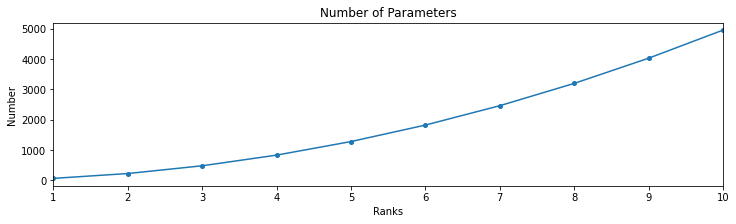

In [21]:
fig,ax = plt.subplots()
ax.plot(ranks, parameters, marker='o', markersize=4)
ax.set_title('Number of Parameters')
ax.set_xlabel('Ranks')
ax.set_ylabel('Number')
ax.set_xlim([1,10])

fig.set_size_inches(12,3)

In [22]:
model = best_model
train_loss = best_train_loss
valid_loss = best_valid_loss
trani_acc = best_train_acc
valid_acc = best_valid_acc
weights_XH = best_weights_XH
weights_HH = best_weights_HH

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tt_recurrent_layer_3 (TTRecu (None, 1024)              1050080   
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 3075      
Total params: 1,053,155
Trainable params: 1,053,155
Non-trainable params: 0
_________________________________________________________________


train loss:  0.7918208698068007
validation loss:  0.852397013210251 

train accuracy:  57.03826914313629
validation accuracy:  50.898202450689446 



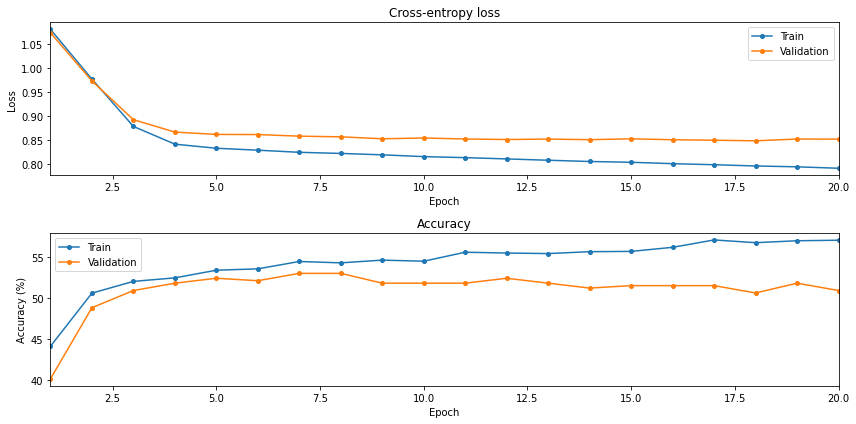

In [23]:
fig, axes = plt.subplots(2,1)

ax=axes[0]
ax.plot([i for i in range(1,epochs+1)], train_loss, marker='o', markersize=4)
ax.plot([i for i in range(1,epochs+1)], valid_loss, marker='o', markersize=4)
ax.legend(['Train', 'Validation'])
ax.set_title('Cross-entropy loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_xlim([1,20])

ax=axes[1]
ax.plot([i for i in range(1,epochs+1)], train_acc, marker='o', markersize=4)
ax.plot([i for i in range(1,epochs+1)], valid_acc, marker='o', markersize=4)
ax.legend(['Train', 'Validation'])
ax.set_title('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (%)')
ax.set_xlim([1,20])

fig.set_size_inches(12,6)
fig.tight_layout()

print('train loss: ',train_loss[19])
print('validation loss: ', valid_loss[19], '\n')

print('train accuracy: ',train_acc[19])
print('validation accuracy: ', valid_acc[19], '\n')

In [24]:
wcore_1 = [] 
wcore_2 = []
wcore_3 = []
wcore_4 = []
wcore_5 = []

for i in range(len(weights_XH)):
  wcore_5.append(weights_XH[i][model.layers[0].indices[4]:model.layers[0].indices[3]])
  wcore_4.append(weights_XH[i][model.layers[0].indices[3]:model.layers[0].indices[2]])
  wcore_3.append(weights_XH[i][model.layers[0].indices[2]:model.layers[0].indices[1]])
  wcore_2.append(weights_XH[i][model.layers[0].indices[1]:model.layers[0].indices[0]])
  wcore_1.append(weights_XH[i][model.layers[0].indices[0]:])

In [25]:
dwcore_1 = []
dwcore_2 = []
dwcore_3 = []
dwcore_4 = []
dwcore_5 = []

for i in range(1,len(weights_XH)):
  dwcore_1.append(np.mean(abs(wcore_1[i]-wcore_1[i-1])))
  dwcore_2.append(np.mean(abs(wcore_2[i]-wcore_2[i-1])))
  dwcore_3.append(np.mean(abs(wcore_3[i]-wcore_3[i-1])))
  dwcore_4.append(np.mean(abs(wcore_4[i]-wcore_4[i-1])))
  dwcore_5.append(np.mean(abs(wcore_5[i]-wcore_5[i-1])))
  
pdwcore_1 = []
pdwcore_2 = []
pdwcore_3 = []
pdwcore_4 = []
pdwcore_5 = []

for i in range(1,len(weights_XH)):
  pdwcore_1.append(100*np.mean(abs((wcore_1[i]-wcore_1[i-1])/wcore_1[i-1])))
  pdwcore_2.append(100*np.mean(abs((wcore_2[i]-wcore_2[i-1])/wcore_2[i-1])))
  pdwcore_3.append(100*np.mean(abs((wcore_3[i]-wcore_3[i-1])/wcore_3[i-1])))
  pdwcore_4.append(100*np.mean(abs((wcore_4[i]-wcore_4[i-1])/wcore_4[i-1])))
  pdwcore_5.append(100*np.mean(abs((wcore_5[i]-wcore_5[i-1])/wcore_5[i-1])))

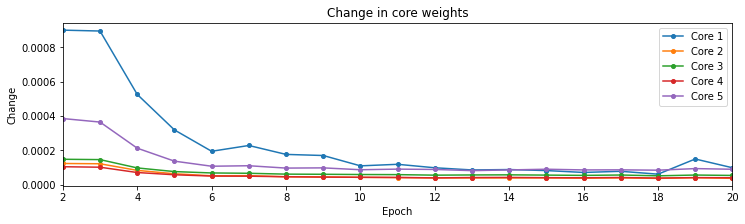

In [26]:
fig, axes = plt.subplots() # plot 3 by 2

axes.plot([i for i in range(2,epochs+1)], dwcore_1, marker='o', markersize=4)
axes.plot([i for i in range(2,epochs+1)], dwcore_2, marker='o', markersize=4)
axes.plot([i for i in range(2,epochs+1)], dwcore_3, marker='o', markersize=4)
axes.plot([i for i in range(2,epochs+1)], dwcore_4, marker='o', markersize=4)
axes.plot([i for i in range(2,epochs+1)], dwcore_5, marker='o', markersize=4)
axes.legend(['Core 1', 'Core 2', 'Core 3', 'Core 4', 'Core 5'], loc='best')
axes.set_title('Change in core weights')
axes.set_xlabel('Epoch')
axes.set_ylabel('Change')
axes.set_xlim([2,20])

fig.set_size_inches(12,3)

## Backtest

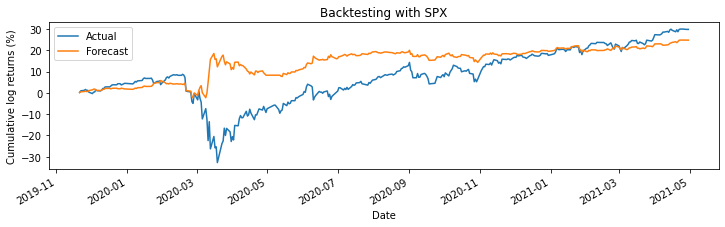

In [27]:
returns = labels['SPX'][-RNN_y_test.shape[0]:]*100
idx = model.predict(RNN_X_test).argmax(1)-1
idx = idx*model.predict(RNN_X_test).max(1)
predicted = returns*idx

returns.index = pd.to_datetime(returns.index)
predicted.index = pd.to_datetime(predicted.index)

fig, ax = plt.subplots()

returns.cumsum().plot()
predicted.cumsum().plot()
plt.legend(['Actual', 'Forecast'], loc='upper left')
plt.title('Backtesting with SPX')
plt.ylabel('Cumulative log returns (%)')
fig.set_size_inches(12,3)

In [28]:
trading_results(predicted)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Total return (%)            24.767446
Accuracy (%)                51.704545
Average return (%)           0.070362
Maximum drawdown (%)       -10.842586
Drawdown duration (Days)    38.000000
Sharpe ratio                 0.072237
Skew                         1.198377
Kurtosis                    10.044680
dtype: float64

In [30]:
# test loss
score = model.evaluate(RNN_X_test,RNN_y_test, batch_size=22*3)
score

352/352 [==============================] - 0s 374us/step


[0.8873486183583736, 0.5142045263200998]

# H-TT Recurrent Neural Network Model

## MDT

It is assumed that mode-0 contains the different features and mode-1 contains the time steps. Thus, the input matrix is as follows: $\textbf{X} \in \mathbb{R}^{I \times T}$.

In [12]:
def make_duplication_matrix(T,tau):
  T_hat = tau*(T-tau+1)

  dup = np.zeros((T,T_hat))
  identity_matrix = np.identity(tau)

  x_left = 0
  x_right = tau
  y_high = 0
  y_low = tau

  for i in range(dup.shape[1]):
    
    if(x_right > T_hat or y_low > T):
      break
    else:
      dup[y_high:y_low,x_left:x_right] = identity_matrix

      x_left=x_right
      x_right+=tau
      y_high+=1
      y_low+=1

  return dup

In [13]:
def make_embedded_matrix(input_matrix,duplicate_matrix):
  return np.matmul(input_matrix,duplicate_matrix)

In [14]:
def convert_embedded_matrix_to_tensor(input_matrix,num_time_series,tau,T):
  T_hat = T-tau+1
  new_tensor = np.zeros((num_time_series,tau,T_hat))
  tau_slide_start = 0
  tau_slide_end = tau_slide_start+tau

  for i in range(T_hat):
    new_tensor[:,:,i] = input_matrix[:,tau_slide_start:tau_slide_end]
    tau_slide_start = tau_slide_end
    tau_slide_end+=tau

  return new_tensor

In [15]:
def higher_order_tensor(input,tau):
  T = input.shape[1]
  num_time_series = input.shape[0]
  duplicate_matrix = make_duplication_matrix(T,tau)
  embedded_input = make_embedded_matrix(input,duplicate_matrix)
  output_tensor = convert_embedded_matrix_to_tensor(embedded_input,num_time_series,tau,T)
  return output_tensor

In [16]:
def higher_order_matrix(input,tau):
  T = input.shape[1]
  num_time_series = input.shape[0]
  duplicate_matrix = make_duplication_matrix(T,tau)
  embedded_input = make_embedded_matrix(input,duplicate_matrix)
  return embedded_input

### Testing MDT

In [17]:
### TEST MDT

# test with T=8, tau=3
# create five time series

num_time_series = 5
T=8
tau=3

#v = np.zeros((1,7))
#v[0,0] = 2
#v[0,1] = 4
#v[0,2] = 6
#v[0,3] = 8
#v[0,4] = 10
#v[0,5] = 12
#v[0,6] = 14
#v = [2,4,6,8,10,12,14]

# testing purposes
test_matrix = np.zeros((num_time_series,T))

k = 1

for i in range(num_time_series):
  for j in range(T):
    test_matrix[i,j] = k
    k+=1

print(test_matrix)
print(test_matrix.shape)

[[ 1.  2.  3.  4.  5.  6.  7.  8.]
 [ 9. 10. 11. 12. 13. 14. 15. 16.]
 [17. 18. 19. 20. 21. 22. 23. 24.]
 [25. 26. 27. 28. 29. 30. 31. 32.]
 [33. 34. 35. 36. 37. 38. 39. 40.]]
(5, 8)


In [18]:
#dup_matrix = make_duplication_matrix(7,3)
dup_matrix = make_duplication_matrix(T,tau)
print(dup_matrix)
print(dup_matrix.shape)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
(8, 18)


In [19]:
emb_matrix = make_embedded_matrix(test_matrix,dup_matrix)
print(emb_matrix)

[[ 1.  2.  3.  2.  3.  4.  3.  4.  5.  4.  5.  6.  5.  6.  7.  6.  7.  8.]
 [ 9. 10. 11. 10. 11. 12. 11. 12. 13. 12. 13. 14. 13. 14. 15. 14. 15. 16.]
 [17. 18. 19. 18. 19. 20. 19. 20. 21. 20. 21. 22. 21. 22. 23. 22. 23. 24.]
 [25. 26. 27. 26. 27. 28. 27. 28. 29. 28. 29. 30. 29. 30. 31. 30. 31. 32.]
 [33. 34. 35. 34. 35. 36. 35. 36. 37. 36. 37. 38. 37. 38. 39. 38. 39. 40.]]


In [20]:
output_tensor = convert_embedded_matrix_to_tensor(emb_matrix,num_time_series,tau,T)
print(output_tensor.shape)

for i in range(output_tensor.shape[2]):
  print(output_tensor[:,:,i],'\n')

(5, 3, 6)
[[ 1.  2.  3.]
 [ 9. 10. 11.]
 [17. 18. 19.]
 [25. 26. 27.]
 [33. 34. 35.]] 

[[ 2.  3.  4.]
 [10. 11. 12.]
 [18. 19. 20.]
 [26. 27. 28.]
 [34. 35. 36.]] 

[[ 3.  4.  5.]
 [11. 12. 13.]
 [19. 20. 21.]
 [27. 28. 29.]
 [35. 36. 37.]] 

[[ 4.  5.  6.]
 [12. 13. 14.]
 [20. 21. 22.]
 [28. 29. 30.]
 [36. 37. 38.]] 

[[ 5.  6.  7.]
 [13. 14. 15.]
 [21. 22. 23.]
 [29. 30. 31.]
 [37. 38. 39.]] 

[[ 6.  7.  8.]
 [14. 15. 16.]
 [22. 23. 24.]
 [30. 31. 32.]
 [38. 39. 40.]] 



In [21]:
# test the single tensorization function

out_tensor = higher_order_tensor(test_matrix,3)
print(out_tensor.shape)

for i in range(out_tensor.shape[2]):
  print(out_tensor[:,:,i],'\n')


(5, 3, 6)
[[ 1.  2.  3.]
 [ 9. 10. 11.]
 [17. 18. 19.]
 [25. 26. 27.]
 [33. 34. 35.]] 

[[ 2.  3.  4.]
 [10. 11. 12.]
 [18. 19. 20.]
 [26. 27. 28.]
 [34. 35. 36.]] 

[[ 3.  4.  5.]
 [11. 12. 13.]
 [19. 20. 21.]
 [27. 28. 29.]
 [35. 36. 37.]] 

[[ 4.  5.  6.]
 [12. 13. 14.]
 [20. 21. 22.]
 [28. 29. 30.]
 [36. 37. 38.]] 

[[ 5.  6.  7.]
 [13. 14. 15.]
 [21. 22. 23.]
 [29. 30. 31.]
 [37. 38. 39.]] 

[[ 6.  7.  8.]
 [14. 15. 16.]
 [22. 23. 24.]
 [30. 31. 32.]
 [38. 39. 40.]] 



In [22]:
out_matrix = higher_order_matrix(test_matrix,3)
print(out_matrix)

[[ 1.  2.  3.  2.  3.  4.  3.  4.  5.  4.  5.  6.  5.  6.  7.  6.  7.  8.]
 [ 9. 10. 11. 10. 11. 12. 11. 12. 13. 12. 13. 14. 13. 14. 15. 14. 15. 16.]
 [17. 18. 19. 18. 19. 20. 19. 20. 21. 20. 21. 22. 21. 22. 23. 22. 23. 24.]
 [25. 26. 27. 26. 27. 28. 27. 28. 29. 28. 29. 30. 29. 30. 31. 30. 31. 32.]
 [33. 34. 35. 34. 35. 36. 35. 36. 37. 36. 37. 38. 37. 38. 39. 38. 39. 40.]]


## Pre-processing of Data

### Tau

In [35]:
tau = 3 # one of the hyperparameters

In [36]:
labels = pd.read_csv('drive/My Drive/FYP Data/labels.csv', index_col=0, header=0)
output = np.sign(labels['SPX'])+1 # 0,1,2 or negative, neutral, positive
output = to_categorical(output)

In [37]:
X = np.zeros((3735,180))

for ticker in tickers:
  tmp_idx1 = tickers.index(ticker)*15
  tmp_idx2 = tmp_idx1+15
  X[:, tmp_idx1:tmp_idx2] = get_data(ticker).values

In [38]:
split_idx = int(3735*0.9)

X_train = X[:split_idx]
X_test = X[split_idx:]
y_train = output[:split_idx]
y_test = output[split_idx:]

In [39]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [40]:
# take transpose of the data
X_train = X_train.T
y_train = y_train.T

### Apply MDT

In [41]:
print(X_train.shape)
print(y_train.shape)

#X_tr_MDT = higher_order_tensor(X_tr,tau)
#y_tr_MDT = higher_order_tensor(y_tr,tau)

X_train_MDT = higher_order_matrix(X_train,tau)
y_train_MDT = higher_order_matrix(y_train,tau)

print(X_train_MDT.shape)
print(y_train_MDT.shape)

(180, 3361)
(3, 3361)
(180, 10077)
(3, 10077)


In [42]:
X_train_MDT = X_train_MDT.T
y_train_MDT = y_train_MDT.T

In [43]:
print(X_train_MDT.shape)
print(y_train_MDT.shape)

(10077, 180)
(10077, 3)


In [44]:
# Reformat the data for recurrent models by adding time steps

orig_time_step = 22 # using just this gives poor results
#time_step = orig_time_step*tau-1 # used to be 22, aka one trading month, tested this with okay results
time_step = orig_time_step*tau-1

# Hankelized
RNN_X_train = np.zeros((X_train_MDT.shape[0]-time_step,time_step,180)) # number of samples, time step, features*assets*asset classes
RNN_y_train = np.zeros((y_train_MDT.shape[0]-time_step,y_train_MDT.shape[1]))

# not Hankelized
RNN_X_test = np.zeros((X_test.shape[0]-time_step,time_step,180)) # number of samples, time step, features*assets*asset classes
RNN_y_test = np.zeros((y_test.shape[0]-time_step,y_test.shape[1]))

# Hankelized
for i in range(time_step, X_train_MDT.shape[0]):
  RNN_X_train[i-time_step]=X_train_MDT[i-time_step:i]
  RNN_y_train[i-time_step]=y_train_MDT[:i][-1]
  
# not Hankelized
for i in range(time_step, X_test.shape[0]):
  RNN_X_test[i-time_step]=X_test[i-time_step:i]
  RNN_y_test[i-time_step]=y_test[:i][-1]

In [46]:
print(RNN_X_train.shape)
print(RNN_X_test.shape)
print(RNN_y_train.shape)
print(RNN_y_test.shape)

(10012, 65, 180)
(309, 65, 180)
(10012, 3)
(309, 3)


## Model Training

In [47]:
epochs = 20
orig_batch_size = 22*3
batch_size = orig_batch_size*tau-1
ranks = [1,2,3,4,5,6,7,8,9,10]
parameters = []

# so far tried:
# 1x5x3x4x3 best
# 1x5x3x3x4 not good
# 1x3x5x4x3 not good

tt_input = [1,5,3,4,3]
tt_output = [4,4,4,4,4]

train_losses = pd.Series()
test_losses = pd.Series()
trading_res = pd.DataFrame()
best_return = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  app.launch_new_instance()


In [48]:
for r in ranks:
  tt_ranks = [1,r,r,r,r,1]
  model = create_TTRNN(tt_input,tt_output,tt_ranks)

  train_loss = []
  valid_loss = []
  train_acc = []
  valid_acc = []

  weights_XH = []
  weights_HH = []

  for e in range(epochs):
      print('epoch: ', e)
      history = model.fit(x=RNN_X_train, y=RNN_y_train, verbose=1, epochs=1, batch_size=batch_size, validation_split=0.1)
      train_loss.append(history.history['loss'][0])
      valid_loss.append(history.history['val_loss'][0])
      train_acc.append(history.history['acc'][0]*100)
      valid_acc.append(history.history['val_acc'][0]*100)

      weights = model.get_weights()
      weights_XH.append(weights[0])
      weights_HH.append(weights[2])

  parameters.append(np.sum(np.array(tt_input)*np.array(tt_output)*np.array(tt_ranks)[1:]*np.array(tt_ranks)[:-1]))

  if not r in trading_res.columns:
    train_losses[str(r)] = model.evaluate(RNN_X_train, RNN_y_train, verbose=0)[0]
    test_losses[str(r)] = model.evaluate(RNN_X_test, RNN_y_test, verbose=0)[0]
  
  returns = labels['SPX'][-RNN_y_test.shape[0]:]*100
  idx = model.predict(RNN_X_test).argmax(1)-1
  idx = idx*model.predict(RNN_X_test).max(1)
  predicted = returns*idx

  if not r in trading_res.columns:
    trading_res[r] = trading_results(predicted)
    print(trading_res)
  if trading_res[r]['Accuracy (%)'] > 0.5:
    if trading_res[r]['Total return (%)'] > best_return:
      best_return = trading_res[r]['Total return (%)']
      best_model = model
      best_result = trading_res[r]['Total return (%)']
      best_train_loss = train_loss
      best_valid_loss = valid_loss
      best_train_acc = train_acc
      best_valid_acc = valid_acc
      best_weights_XH = weights_XH
      best_weights_HH = weights_HH



epoch:  0


Model TT ranks: [1 1 1 1 1 1]
TT number of parameters:  64
Equivalent fully connected layer parameters:  184320

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 9010 samples, validate on 1002 samples
Epoch 1/1





9010/9010 [==============================] - 10s 1ms/step - loss: 1.0098 - acc: 0.4461 - val_loss: 0.8649 - val_acc: 0.5080
epoch:  1
Train on 9010 samples, validate on 1002 samples
Epoch 1/1
9010/9010 [==============================] - 9s 1ms/step - loss: 0.8411 - acc: 0.5173 - val_loss: 0.8211 - val_acc: 0.5200
epoch:  2
Train on 9010 samples, validate on 1002 samples
Epoch 1/1
9010/9010 [==============================] - 9s 1ms/step - loss: 0.8339 - acc: 0.5229 - val_loss: 0.8203 - val_acc: 0.5210
epoch:  3
Train on 9010 samples, validate on 1002 samples
Epoch 1/1
9010/9010 [==============================] - 9s 1ms/step - loss: 0.8316 - acc: 0.5251 - val_loss: 0.8194 - val_acc: 0.5150
epoch:  4
Train 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


                                  1
Total return (%)          20.631496
Accuracy (%)              52.427184
Average return (%)         0.066769
Maximum drawdown (%)     -11.369877
Drawdown duration (Days)   5.000000
Sharpe ratio               0.059959
Skew                      -0.663411
Kurtosis                   9.261725
epoch:  0
Model TT ranks: [1 2 2 2 2 1]
TT number of parameters:  224
Equivalent fully connected layer parameters:  184320
Train on 9010 samples, validate on 1002 samples
Epoch 1/1
9010/9010 [==============================] - 10s 1ms/step - loss: 1.0226 - acc: 0.4327 - val_loss: 0.9389 - val_acc: 0.4930
epoch:  1
Train on 9010 samples, validate on 1002 samples
Epoch 1/1
9010/9010 [==============================] - 10s 1ms/step - loss: 0.8478 - acc: 0.5110 - val_loss: 0.8504 - val_acc: 0.5170
epoch:  2
Train on 9010 samples, validate on 1002 samples
Epoch 1/1
9010/9010 [==============================] - 10s 1ms/step - loss: 0.8330 - acc: 0.5220 - val_loss: 0.8534 - val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


                                  1           2
Total return (%)          20.631496  -21.712922
Accuracy (%)              52.427184   46.925566
Average return (%)         0.066769   -0.070268
Maximum drawdown (%)     -11.369877  -28.340459
Drawdown duration (Days)   5.000000  253.000000
Sharpe ratio               0.059959   -0.053505
Skew                      -0.663411   -1.621748
Kurtosis                   9.261725   16.669796
epoch:  0
Model TT ranks: [1 3 3 3 3 1]
TT number of parameters:  480
Equivalent fully connected layer parameters:  184320
Train on 9010 samples, validate on 1002 samples
Epoch 1/1
9010/9010 [==============================] - 11s 1ms/step - loss: 1.0501 - acc: 0.4261 - val_loss: 0.9406 - val_acc: 0.4760
epoch:  1
Train on 9010 samples, validate on 1002 samples
Epoch 1/1
9010/9010 [==============================] - 10s 1ms/step - loss: 0.8588 - acc: 0.5148 - val_loss: 0.8317 - val_acc: 0.4840
epoch:  2
Train on 9010 samples, validate on 1002 samples
Epoch 1/1
901

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


                                  1           2           3
Total return (%)          20.631496  -21.712922  -10.101957
Accuracy (%)              52.427184   46.925566   42.718447
Average return (%)         0.066769   -0.070268   -0.032692
Maximum drawdown (%)     -11.369877  -28.340459  -19.032745
Drawdown duration (Days)   5.000000  253.000000  214.000000
Sharpe ratio               0.059959   -0.053505   -0.034866
Skew                      -0.663411   -1.621748    0.395220
Kurtosis                   9.261725   16.669796    8.248177
epoch:  0
Model TT ranks: [1 4 4 4 4 1]
TT number of parameters:  832
Equivalent fully connected layer parameters:  184320
Train on 9010 samples, validate on 1002 samples
Epoch 1/1
9010/9010 [==============================] - 11s 1ms/step - loss: 0.9627 - acc: 0.4523 - val_loss: 0.8364 - val_acc: 0.4910
epoch:  1
Train on 9010 samples, validate on 1002 samples
Epoch 1/1
9010/9010 [==============================] - 10s 1ms/step - loss: 0.8391 - acc: 0.5107 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


                                  1           2           3           4
Total return (%)          20.631496  -21.712922  -10.101957  -18.451960
Accuracy (%)              52.427184   46.925566   42.718447   45.631068
Average return (%)         0.066769   -0.070268   -0.032692   -0.059715
Maximum drawdown (%)     -11.369877  -28.340459  -19.032745  -31.945689
Drawdown duration (Days)   5.000000  253.000000  214.000000  135.000000
Sharpe ratio               0.059959   -0.053505   -0.034866   -0.049625
Skew                      -0.663411   -1.621748    0.395220   -0.851206
Kurtosis                   9.261725   16.669796    8.248177   13.120156
epoch:  0
Model TT ranks: [1 5 5 5 5 1]
TT number of parameters:  1280
Equivalent fully connected layer parameters:  184320
Train on 9010 samples, validate on 1002 samples
Epoch 1/1
9010/9010 [==============================] - 12s 1ms/step - loss: 0.9843 - acc: 0.4545 - val_loss: 0.8267 - val_acc: 0.5180
epoch:  1
Train on 9010 samples, validate on 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


                                  1           2  ...           4           5
Total return (%)          20.631496  -21.712922  ...  -18.451960   15.121737
Accuracy (%)              52.427184   46.925566  ...   45.631068   43.689320
Average return (%)         0.066769   -0.070268  ...   -0.059715    0.048938
Maximum drawdown (%)     -11.369877  -28.340459  ...  -31.945689  -12.527364
Drawdown duration (Days)   5.000000  253.000000  ...  135.000000  103.000000
Sharpe ratio               0.059959   -0.053505  ...   -0.049625    0.044222
Skew                      -0.663411   -1.621748  ...   -0.851206    0.836206
Kurtosis                   9.261725   16.669796  ...   13.120156   10.910538

[8 rows x 5 columns]
epoch:  0
Model TT ranks: [1 6 6 6 6 1]
TT number of parameters:  1824
Equivalent fully connected layer parameters:  184320
Train on 9010 samples, validate on 1002 samples
Epoch 1/1
9010/9010 [==============================] - 13s 1ms/step - loss: 0.9548 - acc: 0.4752 - val_loss: 0.83

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


                                  1           2  ...           5          6
Total return (%)          20.631496  -21.712922  ...   15.121737 -27.803697
Accuracy (%)              52.427184   46.925566  ...   43.689320  43.042071
Average return (%)         0.066769   -0.070268  ...    0.048938  -0.089980
Maximum drawdown (%)     -11.369877  -28.340459  ...  -12.527364 -32.513842
Drawdown duration (Days)   5.000000  253.000000  ...  103.000000  21.000000
Sharpe ratio               0.059959   -0.053505  ...    0.044222  -0.082932
Skew                      -0.663411   -1.621748  ...    0.836206  -1.264710
Kurtosis                   9.261725   16.669796  ...   10.910538   9.150407

[8 rows x 6 columns]
epoch:  0
Model TT ranks: [1 7 7 7 7 1]
TT number of parameters:  2464
Equivalent fully connected layer parameters:  184320
Train on 9010 samples, validate on 1002 samples
Epoch 1/1
9010/9010 [==============================] - 13s 1ms/step - loss: 1.0081 - acc: 0.4337 - val_loss: 0.8628 - val_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


                                  1           2  ...          6           7
Total return (%)          20.631496  -21.712922  ... -27.803697  -45.096299
Accuracy (%)              52.427184   46.925566  ...  43.042071   39.805825
Average return (%)         0.066769   -0.070268  ...  -0.089980   -0.145943
Maximum drawdown (%)     -11.369877  -28.340459  ... -32.513842  -46.248532
Drawdown duration (Days)   5.000000  253.000000  ...  21.000000  276.000000
Sharpe ratio               0.059959   -0.053505  ...  -0.082932   -0.130778
Skew                      -0.663411   -1.621748  ...  -1.264710   -1.033109
Kurtosis                   9.261725   16.669796  ...   9.150407    9.100857

[8 rows x 7 columns]
epoch:  0
Model TT ranks: [1 8 8 8 8 1]
TT number of parameters:  3200
Equivalent fully connected layer parameters:  184320
Train on 9010 samples, validate on 1002 samples
Epoch 1/1
9010/9010 [==============================] - 13s 1ms/step - loss: 0.9711 - acc: 0.4743 - val_loss: 0.8354 - val_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


                                  1           2  ...           7          8
Total return (%)          20.631496  -21.712922  ...  -45.096299   3.871297
Accuracy (%)              52.427184   46.925566  ...   39.805825  39.805825
Average return (%)         0.066769   -0.070268  ...   -0.145943   0.012528
Maximum drawdown (%)     -11.369877  -28.340459  ...  -46.248532 -23.199347
Drawdown duration (Days)   5.000000  253.000000  ...  276.000000  16.000000
Sharpe ratio               0.059959   -0.053505  ...   -0.130778   0.011790
Skew                      -0.663411   -1.621748  ...   -1.033109  -0.165497
Kurtosis                   9.261725   16.669796  ...    9.100857  10.896928

[8 rows x 8 columns]
epoch:  0
Model TT ranks: [1 9 9 9 9 1]
TT number of parameters:  4032
Equivalent fully connected layer parameters:  184320
Train on 9010 samples, validate on 1002 samples
Epoch 1/1
9010/9010 [==============================] - 14s 2ms/step - loss: 0.9733 - acc: 0.4592 - val_loss: 0.8425 - val_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


                                  1           2  ...          8           9
Total return (%)          20.631496  -21.712922  ...   3.871297   16.123211
Accuracy (%)              52.427184   46.925566  ...  39.805825   48.220065
Average return (%)         0.066769   -0.070268  ...   0.012528    0.052179
Maximum drawdown (%)     -11.369877  -28.340459  ... -23.199347  -13.553643
Drawdown duration (Days)   5.000000  253.000000  ...  16.000000  113.000000
Sharpe ratio               0.059959   -0.053505  ...   0.011790    0.046798
Skew                      -0.663411   -1.621748  ...  -0.165497    1.149006
Kurtosis                   9.261725   16.669796  ...  10.896928    8.206043

[8 rows x 9 columns]
epoch:  0
Model TT ranks: [ 1 10 10 10 10  1]
TT number of parameters:  4960
Equivalent fully connected layer parameters:  184320
Train on 9010 samples, validate on 1002 samples
Epoch 1/1
9010/9010 [==============================] - 15s 2ms/step - loss: 0.9478 - acc: 0.4812 - val_loss: 0.8145 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [49]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tt_recurrent_layer_10 (TTRec (None, 1024)              1054560   
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 3075      
Total params: 1,057,635
Trainable params: 1,057,635
Non-trainable params: 0
_________________________________________________________________


## Analysis

In [50]:
trading_res

,1,2,3,4,5,6,7,8,9,10
Total return (%),20.631496,-21.712922,-10.101957,-18.451960,15.121737,-27.803697,-45.096299,3.871297,16.123211,6.022995
Accuracy (%),52.427184,46.925566,42.718447,45.631068,43.689320,43.042071,39.805825,39.805825,48.220065,47.249191
Average return (%),0.066769,-0.070268,-0.032692,-0.059715,0.048938,-0.089980,-0.145943,0.012528,0.052179,0.019492
Maximum drawdown (%),-11.369877,-28.340459,-19.032745,-31.945689,-12.527364,-32.513842,-46.248532,-23.199347,-13.553643,-28.685106
Drawdown duration (Days),5.000000,253.000000,214.000000,135.000000,103.000000,21.000000,276.000000,16.000000,113.000000,114.000000
Sharpe ratio,0.059959,-0.053505,-0.034866,-0.049625,0.044222,-0.082932,-0.130778,0.011790,0.046798,0.016791
Skew,-0.663411,-1.621748,0.395220,-0.851206,0.836206,-1.264710,-1.033109,-0.165497,1.149006,0.593754
Kurtosis,9.261725,16.669796,8.248177,13.120156,10.910538,9.150407,9.100857,10.896928,8.206043,12.191779


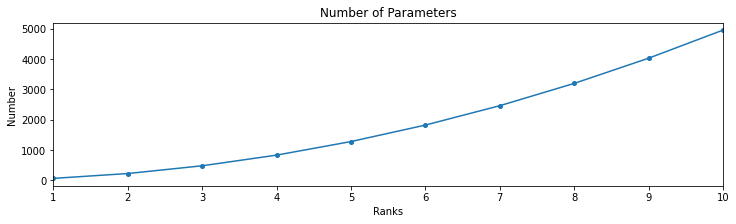

In [51]:
fig,ax = plt.subplots()
ax.plot(ranks, parameters, marker='o', markersize=4)
ax.set_title('Number of Parameters')
ax.set_xlabel('Ranks')
ax.set_ylabel('Number')
ax.set_xlim([1,10])

fig.set_size_inches(12,3)

In [52]:
model = best_model
train_loss = best_train_loss
valid_loss = best_valid_loss
trani_acc = best_train_acc
valid_acc = best_valid_acc
weights_XH = best_weights_XH
weights_HH = best_weights_HH

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tt_recurrent_layer_1 (TTRecu (None, 1024)              1049664   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3075      
Total params: 1,052,739
Trainable params: 1,052,739
Non-trainable params: 0
_________________________________________________________________


train loss:  0.797222257626308
validation loss:  0.8253574557528048 

train accuracy:  59.94450631866709
validation accuracy:  52.09580827764646 



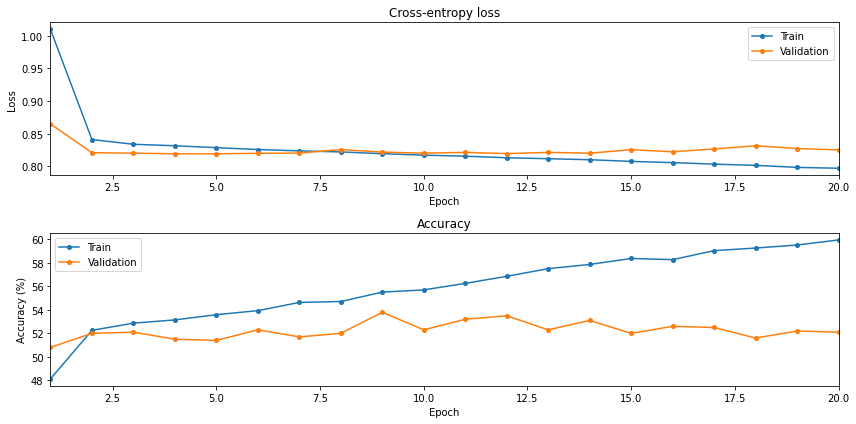

In [53]:
fig, axes = plt.subplots(2,1)

ax=axes[0]
ax.plot([i for i in range(1,epochs+1)], train_loss, marker='o', markersize=4)
ax.plot([i for i in range(1,epochs+1)], valid_loss, marker='o', markersize=4)
ax.legend(['Train', 'Validation'])
ax.set_title('Cross-entropy loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_xlim([1,20])

ax=axes[1]
ax.plot([i for i in range(1,epochs+1)], train_acc, marker='o', markersize=4)
ax.plot([i for i in range(1,epochs+1)], valid_acc, marker='o', markersize=4)
ax.legend(['Train', 'Validation'])
ax.set_title('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (%)')
ax.set_xlim([1,20])

fig.set_size_inches(12,6)
fig.tight_layout()

print('train loss: ',train_loss[19])
print('validation loss: ', valid_loss[19], '\n')

print('train accuracy: ',train_acc[19])
print('validation accuracy: ', valid_acc[19], '\n')

In [54]:
wcore_1 = [] 
wcore_2 = []
wcore_3 = []
wcore_4 = []
wcore_5 = []

for i in range(len(weights_XH)):
  wcore_5.append(weights_XH[i][model.layers[0].indices[4]:model.layers[0].indices[3]])
  wcore_4.append(weights_XH[i][model.layers[0].indices[3]:model.layers[0].indices[2]])
  wcore_3.append(weights_XH[i][model.layers[0].indices[2]:model.layers[0].indices[1]])
  wcore_2.append(weights_XH[i][model.layers[0].indices[1]:model.layers[0].indices[0]])
  wcore_1.append(weights_XH[i][model.layers[0].indices[0]:])

In [55]:
dwcore_1 = []
dwcore_2 = []
dwcore_3 = []
dwcore_4 = []
dwcore_5 = []

for i in range(1,len(weights_XH)):
  dwcore_1.append(np.mean(abs(wcore_1[i]-wcore_1[i-1])))
  dwcore_2.append(np.mean(abs(wcore_2[i]-wcore_2[i-1])))
  dwcore_3.append(np.mean(abs(wcore_3[i]-wcore_3[i-1])))
  dwcore_4.append(np.mean(abs(wcore_4[i]-wcore_4[i-1])))
  dwcore_5.append(np.mean(abs(wcore_5[i]-wcore_5[i-1])))
  
pdwcore_1 = []
pdwcore_2 = []
pdwcore_3 = []
pdwcore_4 = []
pdwcore_5 = []

for i in range(1,len(weights_XH)):
  pdwcore_1.append(100*np.mean(abs((wcore_1[i]-wcore_1[i-1])/wcore_1[i-1])))
  pdwcore_2.append(100*np.mean(abs((wcore_2[i]-wcore_2[i-1])/wcore_2[i-1])))
  pdwcore_3.append(100*np.mean(abs((wcore_3[i]-wcore_3[i-1])/wcore_3[i-1])))
  pdwcore_4.append(100*np.mean(abs((wcore_4[i]-wcore_4[i-1])/wcore_4[i-1])))
  pdwcore_5.append(100*np.mean(abs((wcore_5[i]-wcore_5[i-1])/wcore_5[i-1])))

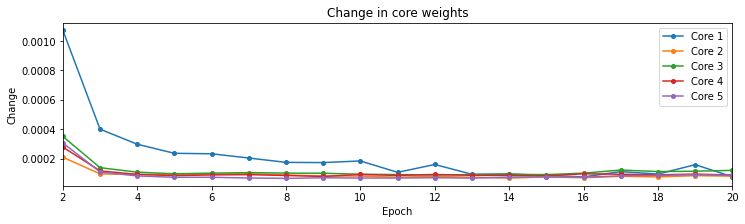

In [56]:
fig, axes = plt.subplots() # plot 3 by 2

axes.plot([i for i in range(2,epochs+1)], dwcore_1, marker='o', markersize=4)
axes.plot([i for i in range(2,epochs+1)], dwcore_2, marker='o', markersize=4)
axes.plot([i for i in range(2,epochs+1)], dwcore_3, marker='o', markersize=4)
axes.plot([i for i in range(2,epochs+1)], dwcore_4, marker='o', markersize=4)
axes.plot([i for i in range(2,epochs+1)], dwcore_5, marker='o', markersize=4)
axes.legend(['Core 1', 'Core 2', 'Core 3', 'Core 4', 'Core 5'], loc='best')
axes.set_title('Change in core weights')
axes.set_xlabel('Epoch')
axes.set_ylabel('Change')
axes.set_xlim([2,20])

fig.set_size_inches(12,3)

## Backtest

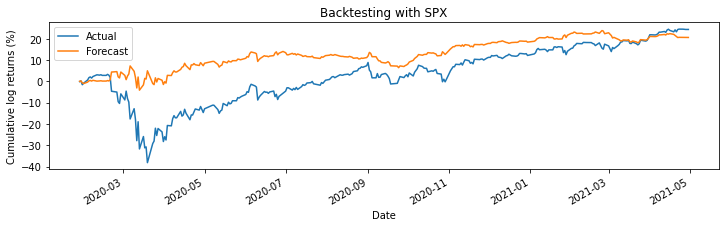

In [57]:
returns = labels['SPX'][-RNN_y_test.shape[0]:]*100
idx = model.predict(RNN_X_test).argmax(1)-1
idx = idx*model.predict(RNN_X_test).max(1)
predicted = returns*idx

returns.index = pd.to_datetime(returns.index)
predicted.index = pd.to_datetime(predicted.index)

fig, ax = plt.subplots()

returns.cumsum().plot()
predicted.cumsum().plot()
plt.legend(['Actual', 'Forecast'], loc='upper left')
plt.title('Backtesting with SPX')
plt.ylabel('Cumulative log returns (%)')
fig.set_size_inches(12,3)

In [58]:
trading_results(predicted)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Total return (%)            20.631496
Accuracy (%)                52.427184
Average return (%)           0.066769
Maximum drawdown (%)       -11.369877
Drawdown duration (Days)     5.000000
Sharpe ratio                 0.059959
Skew                        -0.663411
Kurtosis                     9.261725
dtype: float64

In [59]:
# test loss
score = model.evaluate(RNN_X_test,RNN_y_test, batch_size=22*3)
score

309/309 [==============================] - 0s 894us/step


[0.8408159711985912, 0.524271845528223]